# Fashion-MNIST Classification using Neural Network

In this notebook, we'll build a neural network to classify Fashion-MNIST images

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from collections import OrderedDict

# Download training and testing data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
train_ds = datasets.FashionMNIST('F_MNIST_data', download=True, train=True, transform=transform)
test_ds = datasets.FashionMNIST('F_MNIST_data', download=True, train=False, transform=transform)

100%|██████████| 26421880/26421880 [00:01<00:00, 15334863.98it/s]


Extracting F_MNIST_data\FashionMNIST\raw\train-images-idx3-ubyte.gz to F_MNIST_data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 457199.09it/s]


Extracting F_MNIST_data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to F_MNIST_data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4926108.30it/s]


Extracting F_MNIST_data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to F_MNIST_data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]


Extracting F_MNIST_data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to F_MNIST_data\FashionMNIST\raw



In [3]:
# split train set into training (80%) and validation set (20%)
train_num = len(train_ds)
indices = list(range(train_num))
np.random.shuffle(indices)
split = int(np.floor(0.2 * train_num))
val_idx, train_idx = indices[:split], indices[split:]
len(val_idx), len(train_idx)

(12000, 48000)

In [4]:
# prepare dataloaders
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_idx)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, sampler=train_sampler)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_idx)
val_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, sampler=val_sampler)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True)

torch.Size([1, 28, 28]) torch.Size([64])
Sandal


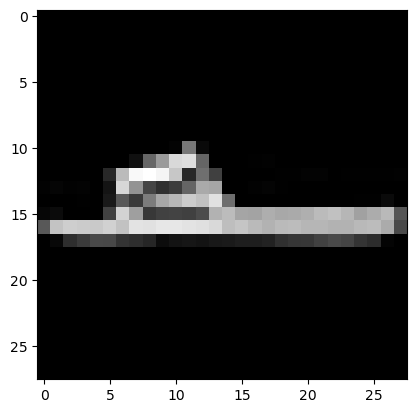

In [5]:
image, label = next(iter(train_dl))
print(image[0].shape, label.shape)
desc = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
print(desc[label[0].item()])
plt.imshow(image[0].numpy().squeeze(), cmap='gray');

## Build the network

In [6]:
def network():
    model = nn.Sequential(OrderedDict([('fc1', nn.Linear(784, 128)),
                                       ('relu1', nn.ReLU()),
                                       ('drop1', nn.Dropout(0.25)),                                       
                                       ('fc2', nn.Linear(128, 64)),
                                       ('relu2', nn.ReLU()),
                                       ('drop1', nn.Dropout(0.25)),                                       
                                       ('output', nn.Linear(64, 10)),
                                       ('logsoftmax', nn.LogSoftmax(dim=1))]))
    # Use GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    # define the criterion and optimizer
    loss_fn = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.003)

    return model, loss_fn, optimizer, device                      

In [7]:
model, loss_fn, optimizer, device = network()
print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)


## Train the network

In [8]:
def train_validate(model, loss_fn, optimizer, trainloader, testloader, device, n_epochs=25):
    train_losses = []
    test_losses = []
    for epoch in range(n_epochs):
        # Set mode to training - Dropouts will be used here
        model.train()
        train_epoch_loss = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            # flatten the images to batch_size x 784
            images = images.view(images.shape[0], -1)
            # forward pass
            outputs = model(images)
            # backpropogation
            train_batch_loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            train_batch_loss.backward()
            # Weight updates
            optimizer.step()
            train_epoch_loss += train_batch_loss.item()
        else:
            # One epoch of training complete
            # calculate average training epoch loss
            train_epoch_loss = train_epoch_loss/len(trainloader)

            # Now Validate on testset
            with torch.no_grad():
                test_epoch_acc = 0
                test_epoch_loss = 0
                # Set mode to eval - Dropouts will NOT be used here
                model.eval()
                for images, labels in testloader:
                    images, labels = images.to(device), labels.to(device)                    
                    # flatten images to batch_size x 784
                    images = images.view(images.shape[0], -1)
                    # make predictions 
                    test_outputs = model(images)
                    # calculate test loss
                    test_batch_loss = loss_fn(test_outputs, labels)
                    test_epoch_loss += test_batch_loss
                    
                    # get probabilities, extract the class associated with highest probability
                    proba = torch.exp(test_outputs)
                    _, pred_labels = proba.topk(1, dim=1)
                    
                    # compare actual labels and predicted labels
                    result = pred_labels == labels.view(pred_labels.shape)
                    batch_acc = torch.mean(result.type(torch.FloatTensor))
                    test_epoch_acc += batch_acc.item()
                else:
                    # One epoch of training and validation done
                    # calculate average testing epoch loss
                    test_epoch_loss = test_epoch_loss/len(testloader)
                    # calculate accuracy as correct_pred/total_samples
                    test_epoch_acc = test_epoch_acc/len(testloader)
                    # save epoch losses for plotting
                    train_losses.append(train_epoch_loss)
                    test_losses.append(test_epoch_loss)
                    # print stats for this epoch
                    print(f'Epoch: {epoch} -> train_loss: {train_epoch_loss:.19f}, val_loss: {test_epoch_loss:.19f}, ',
                          f'val_acc: {test_epoch_acc*100:.2f}%')
    # Finally plot losses
    plt.plot(train_losses, label='train-loss')
    plt.plot(test_losses, label='val-loss')
    plt.legend()
    plt.show()

Epoch: 0 -> train_loss: 0.5717613374392191972, val_loss: 0.4627175927162170410,  val_acc: 82.14%
Epoch: 1 -> train_loss: 0.4544727179209391288, val_loss: 0.3786561787128448486,  val_acc: 86.20%
Epoch: 2 -> train_loss: 0.4215812948346138178, val_loss: 0.3882485926151275635,  val_acc: 86.05%
Epoch: 3 -> train_loss: 0.4067424185574054496, val_loss: 0.3829050660133361816,  val_acc: 85.99%
Epoch: 4 -> train_loss: 0.3922727496027946237, val_loss: 0.3768933117389678955,  val_acc: 86.52%
Epoch: 5 -> train_loss: 0.3795145329733689565, val_loss: 0.3583221137523651123,  val_acc: 87.12%
Epoch: 6 -> train_loss: 0.3709047826528549252, val_loss: 0.3656091392040252686,  val_acc: 86.76%
Epoch: 7 -> train_loss: 0.3617105371852715745, val_loss: 0.3716640174388885498,  val_acc: 86.46%
Epoch: 8 -> train_loss: 0.3574129518767197866, val_loss: 0.3853926062583923340,  val_acc: 86.80%
Epoch: 9 -> train_loss: 0.3483121426006158261, val_loss: 0.3464359045028686523,  val_acc: 87.77%
Epoch: 10 -> train_loss: 0.341

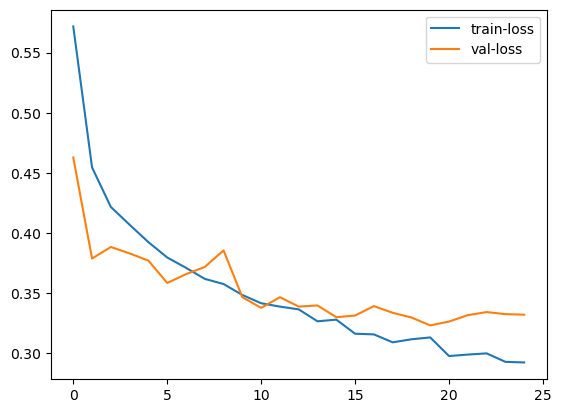

In [9]:
# Train and validate
train_validate(model, loss_fn, optimizer, train_dl, val_dl, device)

### Predict a single image

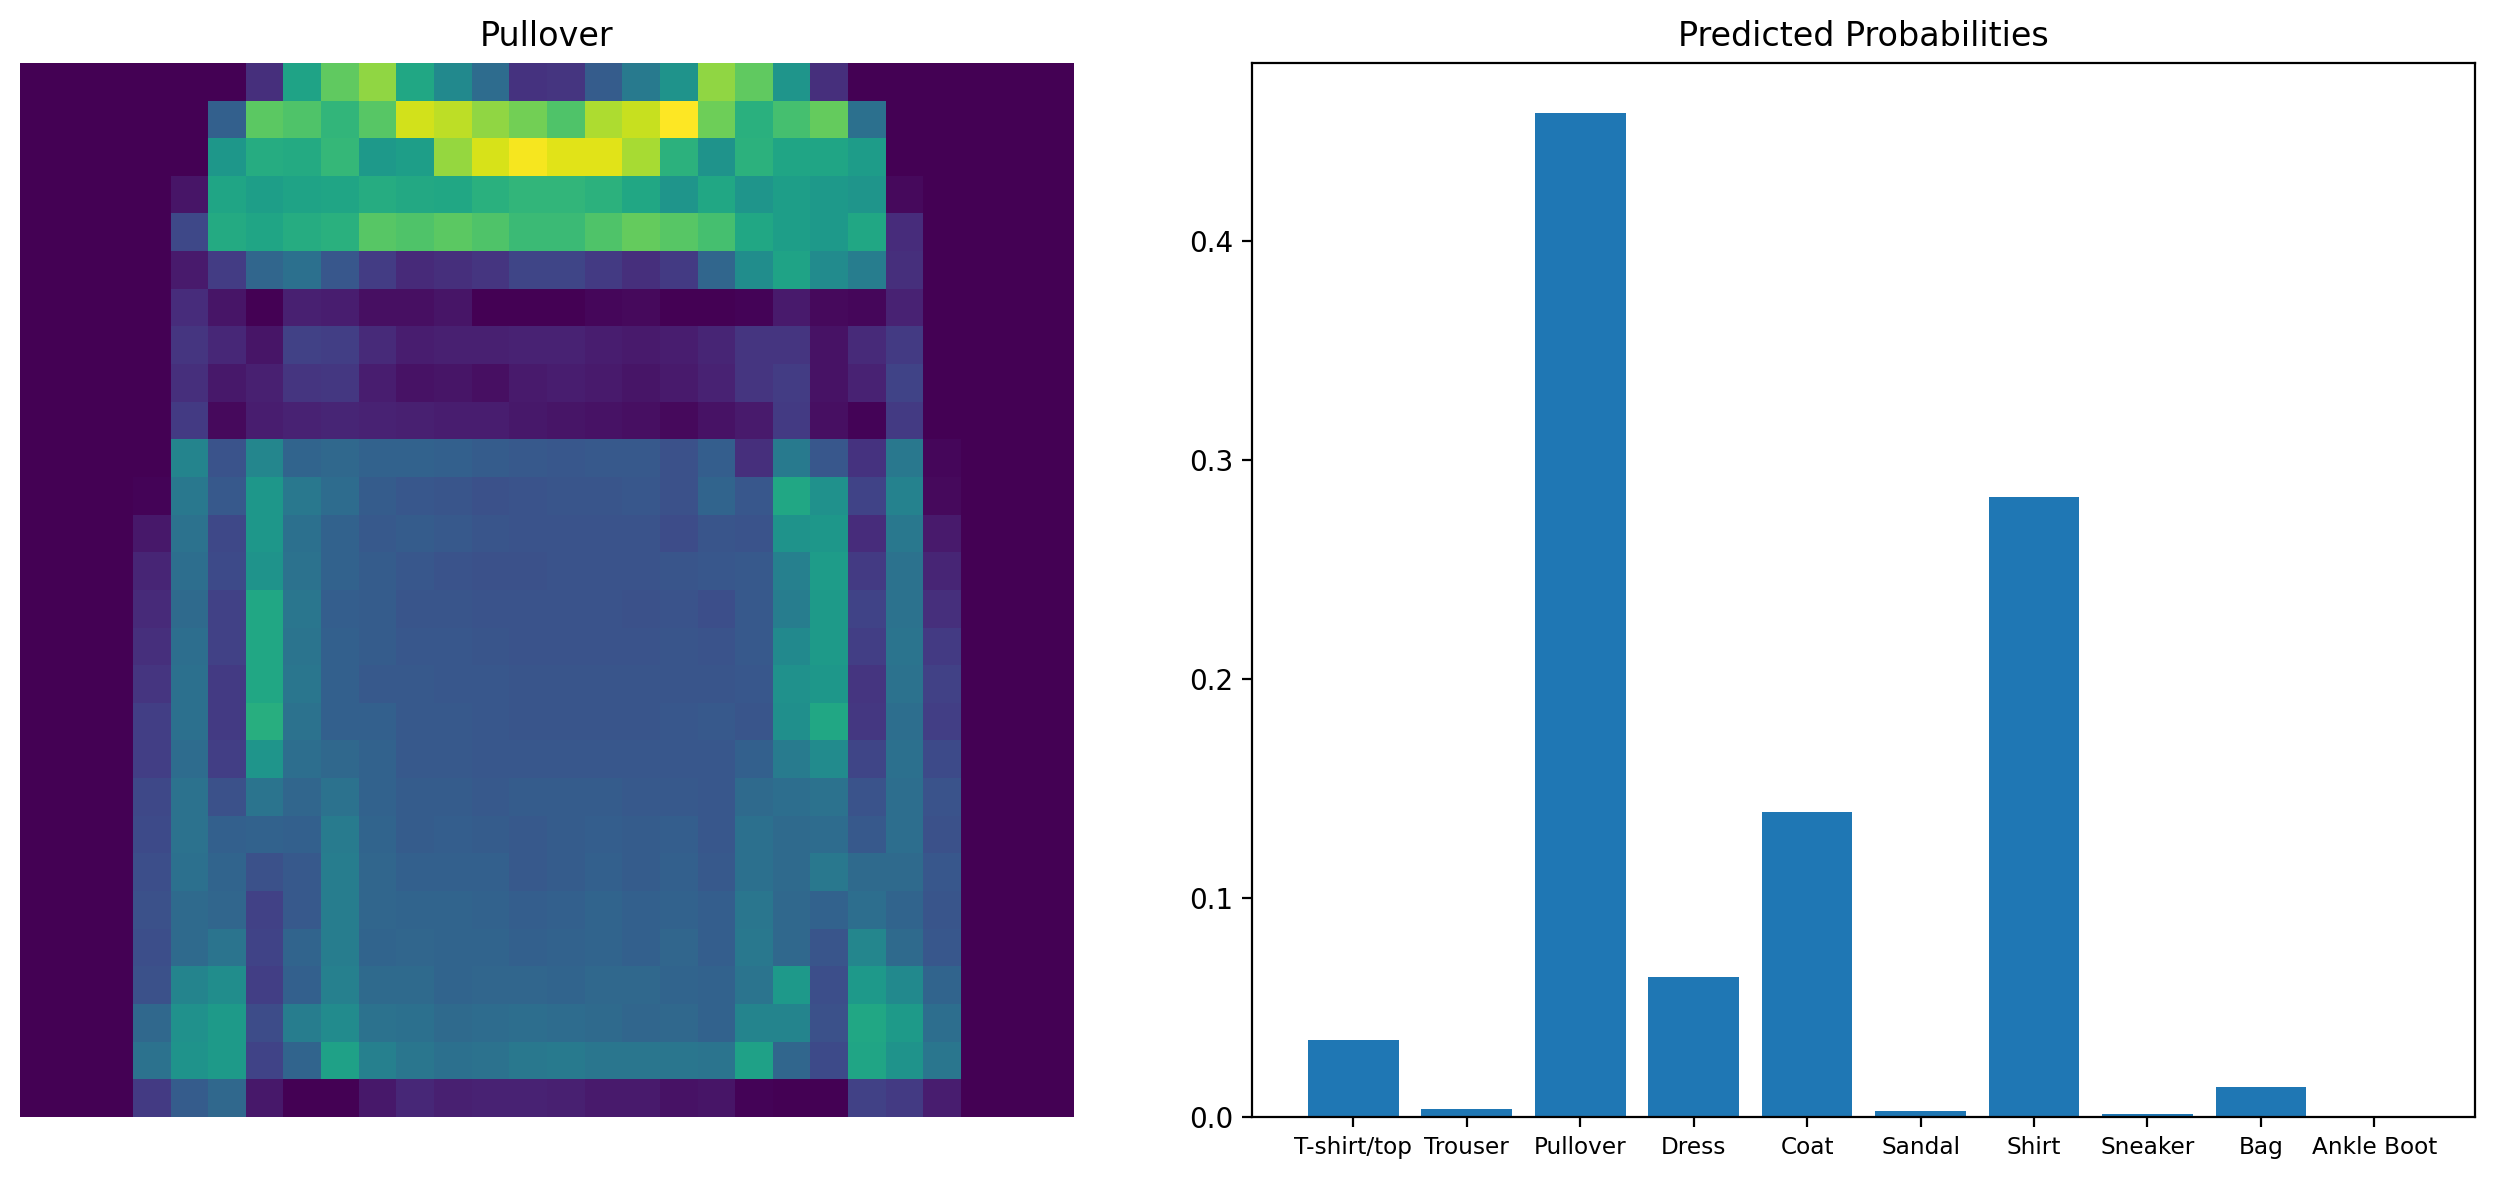

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Assuming test_dl is a DataLoader object
for images, labels in test_dl:
    images, labels = images.to(device), labels.to(device)
    index = 49
    img, label = images[index], labels[index]
    
    # Convert 2D image to 1D vector
    img = img.view(img.shape[0], -1)

    # Calculate the class probabilities (softmax) for img
    proba = torch.exp(model(img))

    # Plot the image and probabilities
    desc = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']
    fig, (ax1, ax2) = plt.subplots(figsize=(13, 6), nrows=1, ncols=2)
    ax1.axis('off')
    ax1.imshow(images[index].cpu().numpy().squeeze())
    ax1.set_title(desc[label.item()])
    ax2.bar(range(10), proba.detach().cpu().numpy().squeeze())
    ax2.set_xticks(range(10))
    ax2.set_xticklabels(desc, size='small')
    ax2.set_title('Predicted Probabilities')
    plt.tight_layout()
    plt.show()
    break  # Break the loop after processing one batch if you just want to visualize one example

## Validate on test set

In [12]:
# Validate
with torch.no_grad():
    batch_acc = []
    model.eval()
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        # flatten images to batch_size x 784
        images = images.view(images.shape[0], -1)
        # make predictions and get probabilities
        proba = torch.exp(model(images))
        # extract the class associted with highest probability
        _, pred_labels = proba.topk(1, dim=1)
        # compare actual labels and predicted labels
        result = pred_labels == labels.view(pred_labels.shape)
        acc = torch.mean(result.type(torch.FloatTensor))
        batch_acc.append(acc.item())
    else:
        print(f'Test Accuracy: {torch.mean(torch.tensor(batch_acc))*100:.2f}%')

Test Accuracy: 87.47%


## More powerful model

In [13]:
# Redefine network with dropout layers in between
def network():
    model = nn.Sequential(OrderedDict([('fc1', nn.Linear(784, 392)),
                                       ('relu1', nn.ReLU()),
                                       ('drop1', nn.Dropout(0.25)),
                                       ('fc12', nn.Linear(392, 196)),
                                       ('relu2', nn.ReLU()),
                                       ('drop2', nn.Dropout(0.25)),
                                       ('fc3', nn.Linear(196, 98)),
                                       ('relu3', nn.ReLU()),
                                       ('drop3', nn.Dropout(0.25)),                                       
                                       ('fc4', nn.Linear(98, 49)),
                                       ('relu4', nn.ReLU()),
                                       ('output', nn.Linear(49, 10)),
                                       ('logsoftmax', nn.LogSoftmax(dim=1))]))
    
    # Use GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = model.to(device)

    # define the criterion and optimizer
    loss_fn = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0007)

    return model, loss_fn, optimizer, device       

In [14]:
model, loss_fn, optimizer, device = network()
model

Sequential(
  (fc1): Linear(in_features=784, out_features=392, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.25, inplace=False)
  (fc12): Linear(in_features=392, out_features=196, bias=True)
  (relu2): ReLU()
  (drop2): Dropout(p=0.25, inplace=False)
  (fc3): Linear(in_features=196, out_features=98, bias=True)
  (relu3): ReLU()
  (drop3): Dropout(p=0.25, inplace=False)
  (fc4): Linear(in_features=98, out_features=49, bias=True)
  (relu4): ReLU()
  (output): Linear(in_features=49, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

Epoch: 0 -> train_loss: 0.6630893236398697210, val_loss: 0.4284856319427490234,  val_acc: 84.15%
Epoch: 1 -> train_loss: 0.4601909563342730380, val_loss: 0.3839402794837951660,  val_acc: 86.12%
Epoch: 2 -> train_loss: 0.4161914834181467682, val_loss: 0.4223918020725250244,  val_acc: 85.06%
Epoch: 3 -> train_loss: 0.3879029621183872067, val_loss: 0.3574290871620178223,  val_acc: 87.08%
Epoch: 4 -> train_loss: 0.3674145249128341617, val_loss: 0.3522672057151794434,  val_acc: 87.49%
Epoch: 5 -> train_loss: 0.3507567297319570954, val_loss: 0.3333921134471893311,  val_acc: 87.96%
Epoch: 6 -> train_loss: 0.3407081768115361453, val_loss: 0.3221130371093750000,  val_acc: 88.48%
Epoch: 7 -> train_loss: 0.3244037445286909738, val_loss: 0.3275692164897918701,  val_acc: 88.30%
Epoch: 8 -> train_loss: 0.3171111395557721369, val_loss: 0.3277078270912170410,  val_acc: 88.34%
Epoch: 9 -> train_loss: 0.3099034384290377253, val_loss: 0.3137190937995910645,  val_acc: 88.40%
Epoch: 10 -> train_loss: 0.299

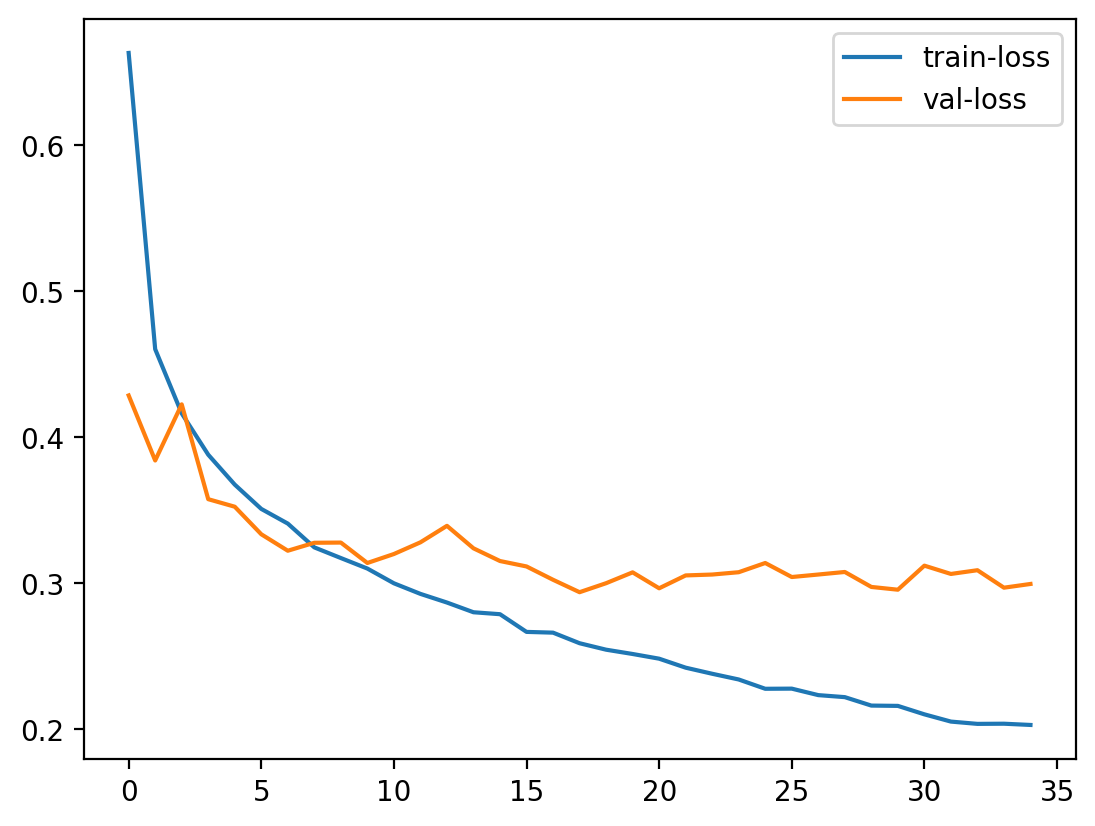

In [15]:
# Train and validate again with new architecture
train_validate(model, loss_fn, optimizer, train_dl, val_dl, device, n_epochs=35)

## Validate on test set

In [16]:
# Validate
with torch.no_grad():
    model.eval()
    batch_acc = []
    for images, labels in test_dl:
        images, labels = images.to(device), labels.to(device)
        # flatten images to batch_size x 784
        images = images.view(images.shape[0], -1)
        # make predictions and get probabilities
        proba = torch.exp(model(images))
        # extract the class associted with highest probability
        _, pred_labels = proba.topk(1, dim=1)
        # compare actual labels and predicted labels
        result = pred_labels == labels.view(pred_labels.shape)
        acc = torch.mean(result.type(torch.FloatTensor))
        batch_acc.append(acc.item())
    else:
        print(f'Accuracy: {torch.mean(torch.tensor(batch_acc))*100:.2f}%')

Accuracy: 89.12%
